# Method: LSTM 
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction of Small Dataset

# 1. Set-up

In [50]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Package
import sys
sys.path.append("../..")

In [51]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [52]:
SEED = 42

In [53]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [54]:
train.data = train.data[:13500]
train.time = train.time[:13500]

In [55]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (13500, 40)
Test size: (90000, 40)


**Create test set**

In [56]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [57]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 2000 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [58]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. LSTM Implementation

In [59]:
def LSTM(h_dim, data_dim, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """
    
    def init_fun(rng):
        """
        This function initialize the weights of the RNN
        
        args:
        ====
         rng: jax RNG
         
        outputs:
        ======
         params: a tuple of parameters
        """
        
        # Forget Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        fU = W_init(k1, (h_dim, data_dim))
        fW = W_init(k2, (h_dim, h_dim)) 
        fb = b_init(k3, (h_dim,))
        
        # Input Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        iU = W_init(k1, (h_dim, data_dim))
        iW = W_init(k2, (h_dim, h_dim))
        ib = b_init(k3, (h_dim,))
        
        # Candidate layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        gU = W_init(k1, (h_dim, data_dim))
        gW = W_init(k2, (h_dim, h_dim))
        gb = b_init(k3, (h_dim,))
        
        # Output layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        oU = W_init(k1, (h_dim, data_dim))
        oW = W_init(k2, (h_dim, h_dim))
        ob = b_init(k3, (h_dim,))
        
        # Dense layer (hidden -> y)
        k1, k2 = jax.random.split(rng, num = 2)
        dO = W_init(k1, (data_dim, h_dim))
        db = b_init(k2, (data_dim,))
                
        params = fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db
        return params
    
    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state
        
        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)
         
        outputs:
        =======
         c_final: jax vector of dimension nn_size
         h_final: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        c_zero = np.zeros((h_dim, ))
        h_zero = np.zeros((h_dim, ))
        
        # forward pass
        def process_internal(start, x):
            c, h = start
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, h) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, h) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, h) + gb)
            c_new = forget_gate * c + input_gate * cand_gate
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, h) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new), y
        (c_final, h_final), pred_traj = jax.lax.scan(process_internal, (c_zero, h_zero), time_series)
        return (c_final, h_final), pred_traj[-1]
    
    
    def forecast(params, internal_states, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.
        
        args:
        ====
         params: tuple of parameters
         internal_states = (c_internal, h_internal): internal state values of c and h
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction
         
        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        c_internal, h_internal = internal_states
        # extract parameters
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        # forward pass
        def forecast_internal(triple_c_h_x, _ ):
            cell, hidden, x = triple_c_h_x
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, hidden) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, hidden) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, hidden) + gb)
            c_new = forget_gate * cell + input_gate * cand_gate
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, hidden) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new, y), y
        
        _, pred_traj = jax.lax.scan(forecast_internal, (c_internal, h_internal, x_input), None, length=horizon)
        
        # return the trajectory of predictions
        return pred_traj
    
    return init_fun, process, forecast

In [65]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 10):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
                
        loss_train_traj = []
        loss_train_all_traj = []
        
        best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 20 == 0:
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if best_mse < early_stopping_baseline and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize LSTM
    init_fun, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [66]:
def get_test_pred(data_test, params, lstm_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = lstm_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Parameter tuning

There are 3 parameters to tune
- nn_size [100, 500, 1000, 1500] - size of the hidden layer
- L_forecast_train [4, 8, 16] - steps forward considered when calculating loss during training
- L_past [1, 8, 16] - length of time series used as input during training 

As a full grid search will be computationally expensive, nn_size is first tuned using a fixed L_forecast_train and L_past, then a grid search is performed on the optimal nn_size

## 3.1 nn_size

**Parameters**
- nn_size = [100, 500, 1000, 1500]
- L_forecast_train = 8
- L_past = 4

In [67]:
L_forecast_train = 8
L_past = 4
b_size = 128 # Batch size
lr_list = [1e-2, 1e-3, 1e-4] # Learning rate schedule
epoch_list = [200, 400, 200]  # Number of epochs for each learning rate

### 3.1.1 nn_size = 100

In [68]:
nn_size = 100

In [69]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,)

Backpropogation start

Epoch 20: Time taken = 0.36 | Train loss = 0.0112423 | Val loss =  1018.9967651
Epoch 40: Time taken = 0.36 | Train loss = 0.0044204 | Val loss =  1294.3311768
Epoch 60: Time taken = 0.37 | Train loss = 0.0025084 | Val loss =  1276.4309082
Epoch 80: Time taken = 0.37 | Train loss = 0.0017445 | Val loss =  1299.1190186
Epoch 100: Time taken = 0.38 | Train loss = 0.0014018 | Val loss =  1123.8170166
Epoch 120: Time taken = 0.38 | Train loss = 0.0012031 | Val loss =  1135.5947266
Epoch 140: Time taken = 0.37 | Train loss = 0.0010957 | Val loss =  1055.6104736
Epoch 160: Time taken = 0.36 | Train loss = 0.0009673 | Val loss =  974.8775635
Epoch 180: Time taken = 0.35 | Train loss = 0.0008879 | Val loss =  992.6353149
Epoch 200: Time taken = 0.34 | Train loss = 0.0008382 | Val loss =  1014.3915405
Best Validation MSE: 40.9868698
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 0.35 | Train loss = 0.0023264 | Val loss =  836.5274658
Epoch 40: Time taken = 0.36 | Train l

In [70]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_1_mu_preds.pkl")

Testing complete. Time taken: 0.54


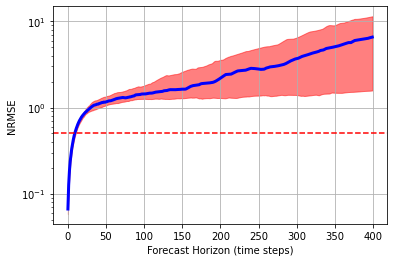

It takes around t = 0.09 for mean error to exceed 0.5


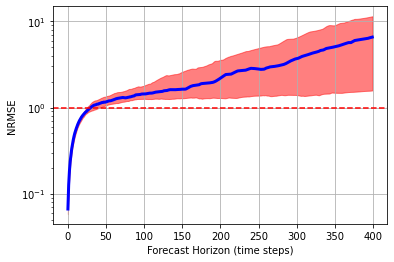

It takes around t = 0.30 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.822
Median NRMSE at t = 0.5: 1.164
Median NRMSE at t = 1: 1.440
Median NRMSE at t = 2: 2.194
Median NRMSE at t = 3: 3.697


In [71]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 500

In [72]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

In [73]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.52 | Train loss = 0.0018375 | Val loss =  2564.9118652
Epoch 40: Time taken = 0.52 | Train loss = 0.0006930 | Val loss =  2379.4191895
Epoch 60: Time taken = 0.52 | Train loss = 0.0003962 | Val loss =  1904.6612549
Epoch 80: Time taken = 0.52 | Train loss = 0.0002800 | Val loss =  1404.5489502
Epoch 100: Time taken = 0.52 | Train loss = 0.0002077 | Val loss =  1144.6138916
Epoch 120: Time taken = 0.53 | Train loss = 0.0001799 | Val loss =  982.9464111
Epoch 140: Time taken = 0.52 | Train loss = 0.0001466 | Val loss =  799.0917358
Epoch 160: Time taken = 0.52 | Train loss = 0.0001228 | Val loss =  749.8937378
Epoch 180: Time taken = 0.52 | Train loss = 0.0001079 | Val loss =  634.1544800
Epoch 200: Time taken = 0.52 | Train loss = 0.0000966 | Val loss =  493.2271423
Epoch 220: Time taken = 0.53 | Train loss = 0.0000917 | Val loss =  557.3887329
Epoch 240: Time taken = 0.53 | Train loss = 0.0000938 | Val loss =  461.4845581
Epoch 260: Time 

In [74]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_2_mu_preds.pkl")

Testing complete. Time taken: 0.68


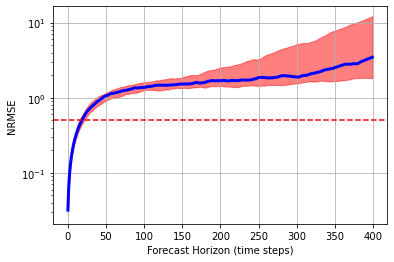

It takes around t = 0.19 for mean error to exceed 0.5


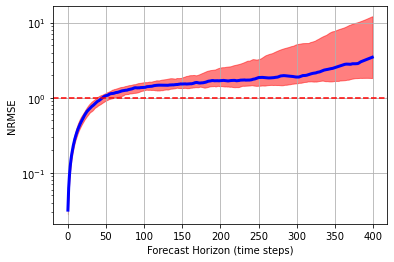

It takes around t = 0.46 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.539
Median NRMSE at t = 0.5: 1.066
Median NRMSE at t = 1: 1.374
Median NRMSE at t = 2: 1.691
Median NRMSE at t = 3: 1.888


In [75]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 1000

In [76]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1000

In [77]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 1.31 | Train loss = 0.0005684 | Val loss =  165.9779816
Epoch 40: Time taken = 1.31 | Train loss = 0.0002982 | Val loss =  20.2245903
Epoch 60: Time taken = 1.32 | Train loss = 0.0002661 | Val loss =  3.8816607
Epoch 80: Time taken = 1.32 | Train loss = 0.0002066 | Val loss =  2.6352265
Epoch 100: Time taken = 1.32 | Train loss = 0.0001492 | Val loss =  2.1395247
Epoch 120: Time taken = 1.32 | Train loss = 0.0001249 | Val loss =  1.9086763
Epoch 140: Time taken = 1.32 | Train loss = 0.0001015 | Val loss =  1.6888826
Epoch 160: Time taken = 1.32 | Train loss = 0.0000788 | Val loss =  1.7037603
Epoch 180: Time taken = 1.32 | Train loss = 0.0000908 | Val loss =  1.5978836
Epoch 200: Time taken = 1.32 | Train loss = 0.0000620 | Val loss =  1.5500590
Epoch 220: Time taken = 1.32 | Train loss = 0.0000596 | Val loss =  1.5368286
Epoch 240: Time taken = 1.32 | Train loss = 0.0000620 | Val loss =  1.4908632
Epoch 260: Time taken = 1.32 | Train loss 

In [78]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_3_mu_preds.pkl")

Testing complete. Time taken: 1.13


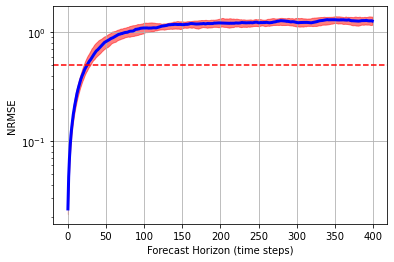

It takes around t = 0.26 for mean error to exceed 0.5


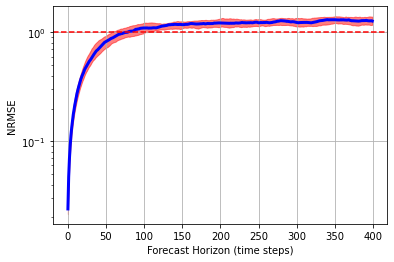

It takes around t = 0.76 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.420
Median NRMSE at t = 0.5: 0.827
Median NRMSE at t = 1: 1.100
Median NRMSE at t = 2: 1.223
Median NRMSE at t = 3: 1.236


In [79]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 1500

In [80]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1500

In [81]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 2.50 | Train loss = 0.0003899 | Val loss =  2.3174376
Epoch 40: Time taken = 2.50 | Train loss = 0.0002819 | Val loss =  1.5268441
Epoch 60: Time taken = 2.51 | Train loss = 0.0003448 | Val loss =  1.4928991
EARLY STOPPING. Epoch 79: Train loss = 0.0002444 | Val loss =  1.5338366
Best Validation MSE: 1.4238693
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 2.51 | Train loss = 0.0001891 | Val loss =  1.5152808
EARLY STOPPING. Epoch 35: Train loss = 0.0001739 | Val loss =  1.5130244
Best Validation MSE: 1.4670563

Epoch 20: Time taken = 2.51 | Train loss = 0.0001574 | Val loss =  1.5024105
EARLY STOPPING. Epoch 35: Train loss = 0.0001209 | Val loss =  1.5120265
Best Validation MSE: 1.4223428
IMPROVED VALIDATION MSE

Total time: 376.66
Complete. Time taken: 376.67s


In [82]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_4_mu_preds.pkl")

Testing complete. Time taken: 1.81


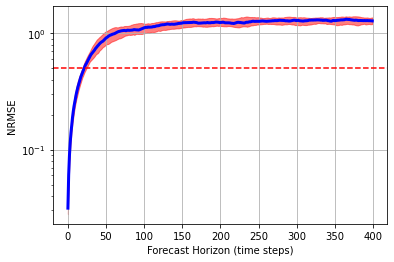

It takes around t = 0.22 for mean error to exceed 0.5


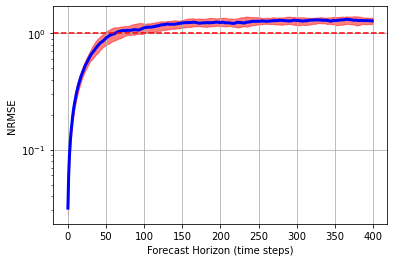

It takes around t = 0.62 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.474
Median NRMSE at t = 0.5: 0.915
Median NRMSE at t = 1: 1.120
Median NRMSE at t = 2: 1.245
Median NRMSE at t = 3: 1.294


In [83]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 L_forecast_train + L_past

**Parameters**
- nn_size = 500
- L_forecast_train = [1, 8, 16]
- L_past = [4, 8, 16]

In [84]:
nn_size = 1000
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.2.1 L_forecast_train = 4, L_past = 1

In [85]:
L_forecast_train = 4; L_past = 1

In [86]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.54 | Train loss = 0.0004743 | Val loss =  261.3820190
Epoch 40: Time taken = 0.54 | Train loss = 0.0001343 | Val loss =  103.2479172
Epoch 60: Time taken = 0.54 | Train loss = 0.0000658 | Val loss =  78.1077957
Epoch 80: Time taken = 0.54 | Train loss = 0.0000442 | Val loss =  35.5982399
Epoch 100: Time taken = 0.54 | Train loss = 0.0000325 | Val loss =  25.3890247
Epoch 120: Time taken = 0.55 | Train loss = 0.0000281 | Val loss =  18.5687962
Epoch 140: Time taken = 0.55 | Train loss = 0.0000252 | Val loss =  7.4708557
Epoch 160: Time taken = 0.55 | Train loss = 0.0000198 | Val loss =  8.4941301
Epoch 180: Time taken = 0.54 | Train loss = 0.0000188 | Val loss =  6.1759934
Epoch 200: Time taken = 0.54 | Train loss = 0.0000135 | Val loss =  4.4924068
Epoch 220: Time taken = 0.55 | Train loss = 0.0000148 | Val loss =  3.5066874
Epoch 240: Time taken = 0.55 | Train loss = 0.0000142 | Val loss =  3.4289119
Epoch 260: Time taken = 0.55 | Train 

In [87]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_2_1_mu_preds.pkl")

Testing complete. Time taken: 1.12


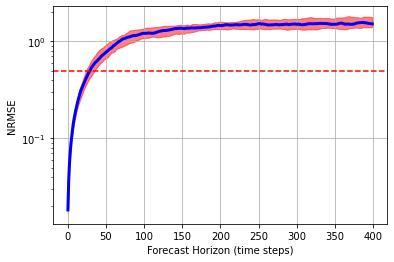

It takes around t = 0.29 for mean error to exceed 0.5


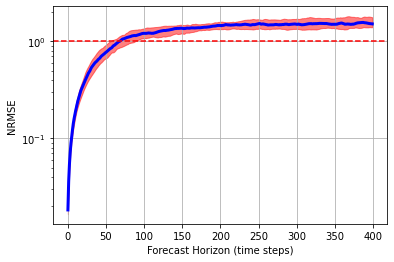

It takes around t = 0.68 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.354
Median NRMSE at t = 0.5: 0.774
Median NRMSE at t = 1: 1.213
Median NRMSE at t = 2: 1.459
Median NRMSE at t = 3: 1.504


In [88]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 L_forecast_train = 4, L_past = 4

In [89]:
L_forecast_train = 4; L_past = 4

In [90]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.90 | Train loss = 0.0002954 | Val loss =  1140.1431885
Epoch 40: Time taken = 0.90 | Train loss = 0.0001270 | Val loss =  41.5415344
Epoch 60: Time taken = 0.90 | Train loss = 0.0000884 | Val loss =  28.3072948
Epoch 80: Time taken = 0.90 | Train loss = 0.0000676 | Val loss =  39.9808159
Epoch 100: Time taken = 0.90 | Train loss = 0.0000673 | Val loss =  46.9003296
Epoch 120: Time taken = 0.90 | Train loss = 0.0000401 | Val loss =  45.4289474
Epoch 140: Time taken = 0.90 | Train loss = 0.0000396 | Val loss =  27.4905224
Epoch 160: Time taken = 0.90 | Train loss = 0.0000278 | Val loss =  20.7083836
Epoch 180: Time taken = 0.90 | Train loss = 0.0000207 | Val loss =  17.5916023
Epoch 200: Time taken = 0.90 | Train loss = 0.0000215 | Val loss =  13.7652969
Epoch 220: Time taken = 0.90 | Train loss = 0.0000279 | Val loss =  14.6210003
Epoch 240: Time taken = 0.90 | Train loss = 0.0000152 | Val loss =  9.1616726
Epoch 260: Time taken = 0.90 | T

In [91]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_2_2_mu_preds.pkl")

Testing complete. Time taken: 1.17


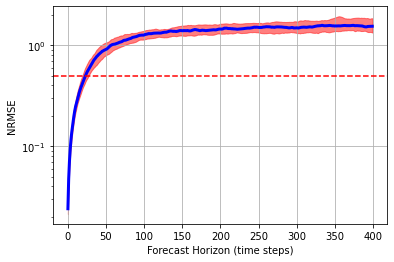

It takes around t = 0.24 for mean error to exceed 0.5


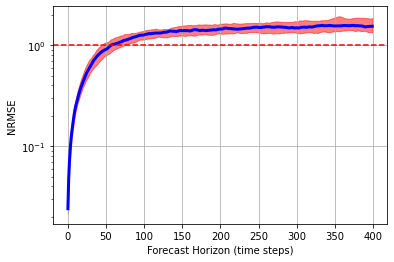

It takes around t = 0.58 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.435
Median NRMSE at t = 0.5: 0.905
Median NRMSE at t = 1: 1.260
Median NRMSE at t = 2: 1.442
Median NRMSE at t = 3: 1.484


In [92]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.3 L_forecast_train = 4, L_past = 8

In [93]:
L_forecast_train = 4; L_past = 8

In [94]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 1.30 | Train loss = 0.0004557 | Val loss =  2255.3115234
Epoch 40: Time taken = 1.30 | Train loss = 0.0001921 | Val loss =  1161.4497070
Epoch 60: Time taken = 1.30 | Train loss = 0.0001367 | Val loss =  152.9068451
Epoch 80: Time taken = 1.29 | Train loss = 0.0001119 | Val loss =  68.1518250
Epoch 100: Time taken = 1.30 | Train loss = 0.0000890 | Val loss =  71.1476135
Epoch 120: Time taken = 1.30 | Train loss = 0.0000881 | Val loss =  115.4572983
Epoch 140: Time taken = 1.30 | Train loss = 0.0001062 | Val loss =  265.3821411
Epoch 160: Time taken = 1.30 | Train loss = 0.0000321 | Val loss =  255.3161316
Epoch 180: Time taken = 1.30 | Train loss = 0.0000424 | Val loss =  257.6948853
Epoch 200: Time taken = 1.29 | Train loss = 0.0000408 | Val loss =  209.0789795
Epoch 220: Time taken = 1.29 | Train loss = 0.0000409 | Val loss =  205.0461731
Epoch 240: Time taken = 1.30 | Train loss = 0.0000265 | Val loss =  154.9404297
Epoch 260: Time taken

In [95]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_2_3_mu_preds.pkl")

Testing complete. Time taken: 1.17


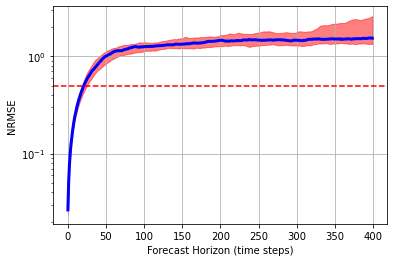

It takes around t = 0.21 for mean error to exceed 0.5


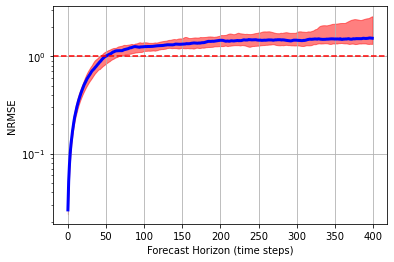

It takes around t = 0.51 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.482
Median NRMSE at t = 0.5: 0.999
Median NRMSE at t = 1: 1.254
Median NRMSE at t = 2: 1.458
Median NRMSE at t = 3: 1.460


In [96]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 L_forecast_train = 8, L_past = 1

In [97]:
L_forecast_train = 8; L_past = 1

In [98]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 0.97 | Train loss = 0.0011645 | Val loss =  36.2328568
Epoch 40: Time taken = 0.96 | Train loss = 0.0004909 | Val loss =  11.3462238
Epoch 60: Time taken = 0.97 | Train loss = 0.0002684 | Val loss =  7.3487792
Epoch 80: Time taken = 0.97 | Train loss = 0.0001779 | Val loss =  3.0013573
Epoch 100: Time taken = 0.97 | Train loss = 0.0001503 | Val loss =  2.5643945
Epoch 120: Time taken = 0.97 | Train loss = 0.0000916 | Val loss =  2.6321175
Epoch 140: Time taken = 0.97 | Train loss = 0.0000814 | Val loss =  2.0878105
Epoch 160: Time taken = 0.97 | Train loss = 0.0000608 | Val loss =  1.9821570
Epoch 180: Time taken = 0.97 | Train loss = 0.0000499 | Val loss =  1.9123930
Epoch 200: Time taken = 0.97 | Train loss = 0.0000608 | Val loss =  1.7784833
Epoch 220: Time taken = 0.97 | Train loss = 0.0000489 | Val loss =  1.7088270
Epoch 240: Time taken = 0.97 | Train loss = 0.0000391 | Val loss =  1.6155007
Epoch 260: Time taken = 0.97 | Train loss =

In [99]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 1.10


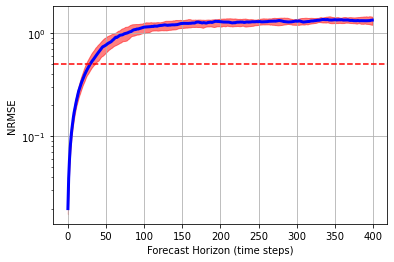

It takes around t = 0.29 for mean error to exceed 0.5


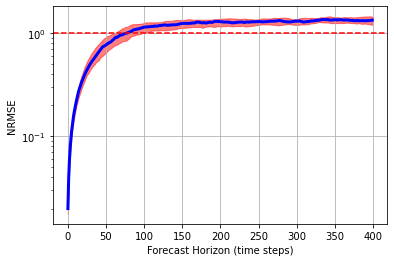

It takes around t = 0.77 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.366
Median NRMSE at t = 0.5: 0.769
Median NRMSE at t = 1: 1.144
Median NRMSE at t = 2: 1.288
Median NRMSE at t = 3: 1.304


In [100]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 L_forecast_train = 8, L_past = 4

In [101]:
L_forecast_train = 8; L_past = 4

In [102]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 1.33 | Train loss = 0.0005684 | Val loss =  165.9779816
Epoch 40: Time taken = 1.33 | Train loss = 0.0002982 | Val loss =  20.2245903
Epoch 60: Time taken = 1.33 | Train loss = 0.0002661 | Val loss =  3.8816607
Epoch 80: Time taken = 1.33 | Train loss = 0.0002066 | Val loss =  2.6352265
Epoch 100: Time taken = 1.33 | Train loss = 0.0001492 | Val loss =  2.1395247
Epoch 120: Time taken = 1.32 | Train loss = 0.0001249 | Val loss =  1.9086763
Epoch 140: Time taken = 1.32 | Train loss = 0.0001015 | Val loss =  1.6888826
Epoch 160: Time taken = 1.33 | Train loss = 0.0000788 | Val loss =  1.7037603
Epoch 180: Time taken = 1.33 | Train loss = 0.0000908 | Val loss =  1.5978836
Epoch 200: Time taken = 1.32 | Train loss = 0.0000620 | Val loss =  1.5500590
Epoch 220: Time taken = 1.33 | Train loss = 0.0000596 | Val loss =  1.5368286
Epoch 240: Time taken = 1.32 | Train loss = 0.0000620 | Val loss =  1.4908632
Epoch 260: Time taken = 1.33 | Train loss 

In [103]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 1.14


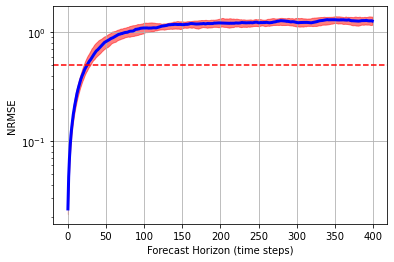

It takes around t = 0.26 for mean error to exceed 0.5


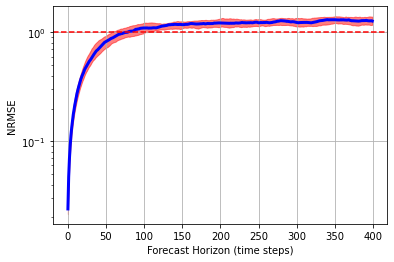

It takes around t = 0.76 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.420
Median NRMSE at t = 0.5: 0.827
Median NRMSE at t = 1: 1.100
Median NRMSE at t = 2: 1.223
Median NRMSE at t = 3: 1.236


In [104]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.6 L_forecast_train = 8, L_past = 8

In [105]:
L_forecast_train = 8; L_past = 8

In [106]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 1.71 | Train loss = 0.0006608 | Val loss =  457.8554382
Epoch 40: Time taken = 1.71 | Train loss = 0.0004859 | Val loss =  89.3563004
Epoch 60: Time taken = 1.71 | Train loss = 0.0003547 | Val loss =  7.4328675
Epoch 80: Time taken = 1.70 | Train loss = 0.0002964 | Val loss =  1.4731833
Epoch 100: Time taken = 1.70 | Train loss = 0.0002192 | Val loss =  1.4312943
EARLY STOPPING. Epoch 119: Train loss = 0.0002214 | Val loss =  1.5397576
Best Validation MSE: 1.3941208
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 1.71 | Train loss = 0.0002107 | Val loss =  1.4330089
EARLY STOPPING. Epoch 34: Train loss = 0.0001933 | Val loss =  1.4568595
Best Validation MSE: 1.3319160
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 1.71 | Train loss = 0.0002034 | Val loss =  1.3886008
EARLY STOPPING. Epoch 32: Train loss = 0.0001714 | Val loss =  1.4671376
Best Validation MSE: 1.2898519
IMPROVED VALIDATION MSE

Total time: 318.83
Complete. Time taken: 318.8

In [107]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 1.12


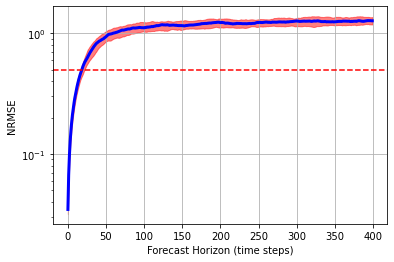

It takes around t = 0.19 for mean error to exceed 0.5


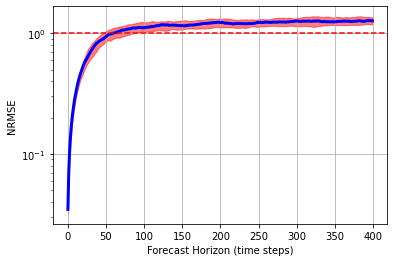

It takes around t = 0.59 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.538
Median NRMSE at t = 0.5: 0.939
Median NRMSE at t = 1: 1.111
Median NRMSE at t = 2: 1.229
Median NRMSE at t = 3: 1.267


In [108]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.7 L_forecast_train = 16, L_past = 1

In [109]:
L_forecast_train = 16; L_past = 1

In [110]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 1.81 | Train loss = 0.0036765 | Val loss =  23.1957722
Epoch 40: Time taken = 1.81 | Train loss = 0.0015581 | Val loss =  11.1672020
Epoch 60: Time taken = 1.81 | Train loss = 0.0011509 | Val loss =  1.9833014
Epoch 80: Time taken = 1.81 | Train loss = 0.0008372 | Val loss =  1.6066954
Epoch 100: Time taken = 1.81 | Train loss = 0.0006051 | Val loss =  1.5155361
Epoch 120: Time taken = 1.81 | Train loss = 0.0005814 | Val loss =  1.4636846
Epoch 140: Time taken = 1.81 | Train loss = 0.0003869 | Val loss =  1.4323769
Epoch 160: Time taken = 1.81 | Train loss = 0.0003714 | Val loss =  1.4548682
Epoch 180: Time taken = 1.81 | Train loss = 0.0003289 | Val loss =  1.3686965
Epoch 200: Time taken = 1.81 | Train loss = 0.0002350 | Val loss =  1.3981791
Epoch 220: Time taken = 1.81 | Train loss = 0.0001963 | Val loss =  1.3776147
Epoch 240: Time taken = 1.81 | Train loss = 0.0001778 | Val loss =  1.3598073
Epoch 260: Time taken = 1.81 | Train loss =

In [111]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 1.11


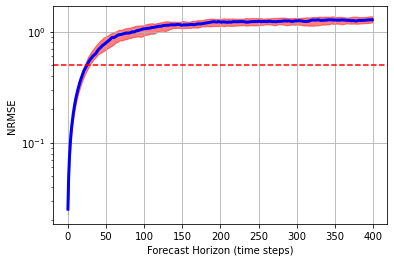

It takes around t = 0.25 for mean error to exceed 0.5


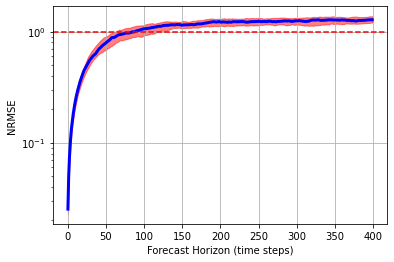

It takes around t = 0.88 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.427
Median NRMSE at t = 0.5: 0.793
Median NRMSE at t = 1: 1.062
Median NRMSE at t = 2: 1.220
Median NRMSE at t = 3: 1.252


In [112]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.8 L_forecast_train = 16, L_past = 4

In [113]:
L_forecast_train = 16; L_past = 4

In [114]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 2.18 | Train loss = 0.0019386 | Val loss =  157.6975861
Epoch 40: Time taken = 2.17 | Train loss = 0.0007797 | Val loss =  52.2014122
Epoch 60: Time taken = 2.18 | Train loss = 0.0007957 | Val loss =  1.8362094
Epoch 80: Time taken = 2.17 | Train loss = 0.0010272 | Val loss =  1.5433317
Epoch 100: Time taken = 2.17 | Train loss = 0.0006553 | Val loss =  1.4939070
Epoch 120: Time taken = 2.17 | Train loss = 0.0004105 | Val loss =  1.4211864
Epoch 140: Time taken = 2.17 | Train loss = 0.0004825 | Val loss =  1.3958796
Epoch 160: Time taken = 2.17 | Train loss = 0.0003404 | Val loss =  1.3931155
EARLY STOPPING. Epoch 174: Train loss = 0.0003115 | Val loss =  1.4150821
Best Validation MSE: 1.3668067
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 2.16 | Train loss = 0.0005261 | Val loss =  1.4576968
Epoch 40: Time taken = 2.16 | Train loss = 0.0003128 | Val loss =  1.4539003
Epoch 60: Time taken = 2.16 | Train loss = 0.0002135 | Val loss =  1.4

In [115]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 1.13


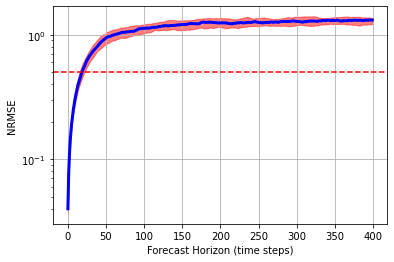

It takes around t = 0.19 for mean error to exceed 0.5


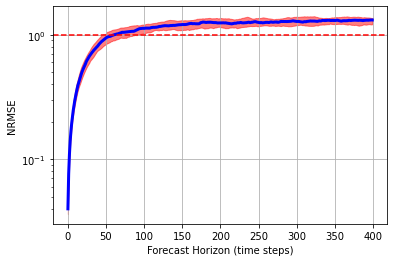

It takes around t = 0.61 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.530
Median NRMSE at t = 0.5: 0.943
Median NRMSE at t = 1: 1.126
Median NRMSE at t = 2: 1.245
Median NRMSE at t = 3: 1.279


In [116]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.9 L_forecast_train = 16, L_past = 8

In [117]:
L_forecast_train = 16; L_past = 8

In [118]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 20: Time taken = 2.55 | Train loss = 0.0015269 | Val loss =  163.4894867
Epoch 40: Time taken = 2.55 | Train loss = 0.0008345 | Val loss =  90.7616730
Epoch 60: Time taken = 2.55 | Train loss = 0.0010690 | Val loss =  1.6083561
Epoch 80: Time taken = 2.55 | Train loss = 0.0010409 | Val loss =  1.4649392
Epoch 100: Time taken = 2.55 | Train loss = 0.0008695 | Val loss =  1.3835543
Epoch 120: Time taken = 2.55 | Train loss = 0.0008118 | Val loss =  1.3859528
Epoch 140: Time taken = 2.55 | Train loss = 0.0005768 | Val loss =  1.3968897
EARLY STOPPING. Epoch 148: Train loss = 0.0006148 | Val loss =  1.4019647
Best Validation MSE: 1.3610630
IMPROVED VALIDATION MSE

Epoch 20: Time taken = 2.55 | Train loss = 0.0006027 | Val loss =  1.4138949
Epoch 40: Time taken = 2.55 | Train loss = 0.0005110 | Val loss =  1.4162823
Epoch 60: Time taken = 2.55 | Train loss = 0.0004710 | Val loss =  1.4038563
EARLY STOPPING. Epoch 63: Train loss = 0.0003736 | Val loss =  1.412089

In [119]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 1.17


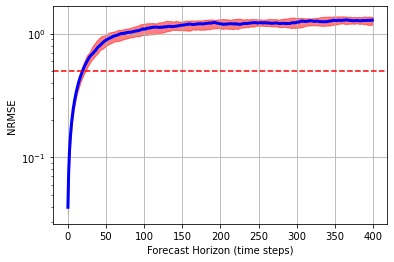

It takes around t = 0.20 for mean error to exceed 0.5


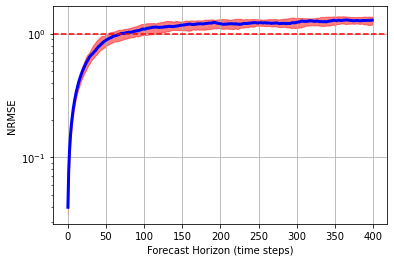

It takes around t = 0.70 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.513
Median NRMSE at t = 0.5: 0.885
Median NRMSE at t = 1: 1.084
Median NRMSE at t = 2: 1.199
Median NRMSE at t = 3: 1.232


In [120]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best Model

nn_size = 100  
L_forecast_train = 8  
L_past = 1

In [121]:
nn_size = 1000
L_forecast_train = 8
L_past = 1

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5, 1e-6] # Learning rate schedule
epoch_list = [400, 200, 200, 200]  # Number of epochs for each learning rate

In [122]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 50)

Backpropogation start

Epoch 20: Time taken = 0.96 | Train loss = 0.0011645 | Val loss =  36.2328568
Epoch 40: Time taken = 0.96 | Train loss = 0.0004909 | Val loss =  11.3462238
Epoch 60: Time taken = 0.97 | Train loss = 0.0002684 | Val loss =  7.3487792
Epoch 80: Time taken = 0.97 | Train loss = 0.0001779 | Val loss =  3.0013573
Epoch 100: Time taken = 0.97 | Train loss = 0.0001503 | Val loss =  2.5643945
Epoch 120: Time taken = 0.97 | Train loss = 0.0000916 | Val loss =  2.6321175
Epoch 140: Time taken = 0.97 | Train loss = 0.0000814 | Val loss =  2.0878105
Epoch 160: Time taken = 0.97 | Train loss = 0.0000608 | Val loss =  1.9821570
Epoch 180: Time taken = 0.97 | Train loss = 0.0000499 | Val loss =  1.9123930
Epoch 200: Time taken = 0.97 | Train loss = 0.0000608 | Val loss =  1.7784833
Epoch 220: Time taken = 0.97 | Train loss = 0.0000489 | Val loss =  1.7088270
Epoch 240: Time taken = 0.97 | Train loss = 0.0000391 | Val loss =  1.6155007
Epoch 260: Time taken = 0.97 | Train loss =

In [123]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.12


In [124]:
save_obj(params, "results/lstm", "best_params.pkl")
save_obj(mean_pred, "results/lstm", "best_mu_preds.pkl")

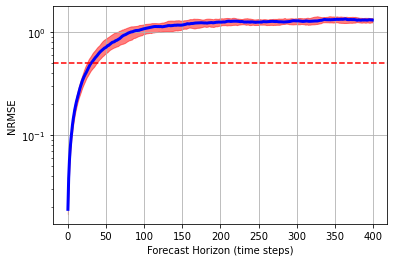

It takes around t = 0.31 for mean error to exceed 0.5


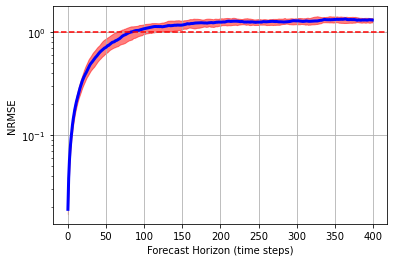

It takes around t = 0.83 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.351
Median NRMSE at t = 0.5: 0.709
Median NRMSE at t = 1: 1.074
Median NRMSE at t = 2: 1.245
Median NRMSE at t = 3: 1.279


In [125]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [13]:
# nn_size = 500
# _, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
# process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
# forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)

In [14]:
# params = load_obj("results/lstm/best_params.pkl")

In [127]:
# mean_pred = get_test_pred(X_test, params, (process_batch, forecast_batch))
# save_obj(mean_pred, "results", "lstm_pred.pkl")

In [128]:
mean_pred = load_obj("results/lstm_pred.pkl")

In [129]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

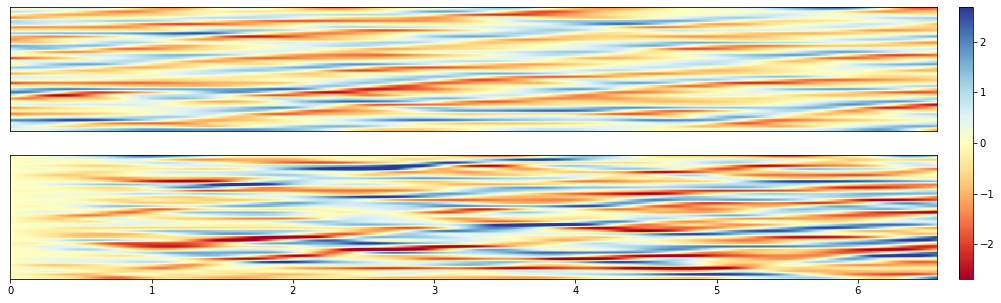

In [130]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_vsmall_lstm", pred_only = True)

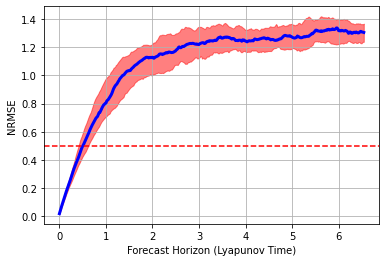

It takes around 0.51 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.493
Median NRMSE at 1.0 Lyapunov Time: 0.804
Median NRMSE at 2.0 Lyapunov Time: 1.128
Median NRMSE at 5.0 Lyapunov Time: 1.272


In [131]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "lorenz_vsmall_lstm_ph")
print()
res_single.get_loss()